# -- Imports --

In [1]:
# in the files used here the caloClusterLinks point somewhere else than what's currently in coffea
# should find a way to generalize this, for now monkey patch it:
import coffea.nanoevents
from coffea.nanoevents import PHYSLITESchema
from coffea.nanoevents.methods.physlite import _element_link_method

PHYSLITESchema.mixins["egammaClusters"] = "NanoCollection"

@property
def caloClusters(self, _dask_array_=None):
    return _element_link_method(
        self, "caloClusterLinks", "egammaClusters", _dask_array_
    )

coffea.nanoevents.methods.physlite.Electron.caloClusters = caloClusters

In [2]:
import copy
import warnings
import functools
from pathlib import Path

import awkward as ak
import dask_awkward as dak
import vector; vector.register_awkward()
import numpy as np
import uproot
from coffea.nanoevents import PHYSLITESchema, NanoEventsFactory

from atlascp import EgammaTools

# Z->ee Demo

Define selections and ee mass with pt correction

In [3]:
GeV = 1000

def electrons_cut(electrons):
        quality_iso_cut = ( ( electrons.DFCommonElectronsLHTight==1 ) &
                    (( electrons.ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000 / (electrons.pt/GeV) ) < 0.04) & 
                    (( electrons.topoetcone20 / (electrons.pt/GeV) ) < 0.15) )

        pt_eta_cut = ( ((electrons.pt/GeV) > 27) & (np.abs(electrons.eta) < 2.470) )
        
        electrons = electrons[(quality_iso_cut & pt_eta_cut)]
        return electrons[diel_cut(electrons)]

def diel_cut(electrons):
        dielectrons_charge_cut = ( (ak.num(electrons.pt, axis=1) == 2) & (ak.sum(electrons.charge, axis=1) == 0) )
        return dielectrons_charge_cut      

def get_corrected_mass(energyCorrectionTool,electrons,sys=None):
    electron_vectors = ak.zip(
        {
            "pt": energyCorrectionTool(electrons,sys=sys).newPt,
            "eta": electrons.eta,
            "phi": electrons.phi,
            "mass": electrons.m,
        },
        with_name="Momentum4D",
    )
    return (electron_vectors[:, 0] + electron_vectors[:, 1]).mass/GeV        

# 1. Get data

In [4]:
if Path('/data/alheld/ATLAS/mc20_13TeV').exists():
    # First check if on UChicago AF
    fname_mc = "/data/alheld/ATLAS/mc20_13TeV/DAOD_PHYSLITE.34869306._000049.pool.root.1"
else:
    # Fallback to EOS
    # If need files from EOS elsewhere make sure to kinit and then use xrdcp
    fname_mc = "/eos/user/e/ekourlit/public/mc20_13TeV/DAOD_PHYSLITE.34869306._000049.pool.root.1"

In [5]:
# for interactive working with dask this is a bit faster since we avoid opening the root file for every .compute()
# also we will make use of the array cache
tree_mc = uproot.open({fname_mc: "CollectionTree"})

In [6]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore") # should at some point make NanoEventsFactory not warn for stuff that we expect to happen
    events_mc = NanoEventsFactory.from_root(tree_mc, schemaclass=PHYSLITESchema, permit_dask=True).events()

# 2. apply selections

In [7]:
mc_electrons = ak.with_field(events_mc.Electrons, 430000, "runNumber")
mc_electrons = electrons_cut(mc_electrons)

# 3. Initialize tools

In [8]:
energyCorrectionTool_mc = EgammaTools.EgammaCalibrationAndSmearingTool()
energyCorrectionTool_mc.setModel(ESModel="es2017_R21_PRE",ResolutionType="Gaussian",decorrelationModel="1NP_v1",datatype="mc")
energyCorrectionTool_mc.initialize()

ready to run on simulation
MyTool_EgammaCalibrati...INFO    Inizializing ColumnarEgammaCalibrationAndSmearingTool
GainUncertainty          INFO    opening file /cvmfs/atlas.cern.ch/repo/sw/database/GroupData/ElectronPhotonFourMomentumCorrection/v11/gain_uncertainty_specialRun.root
EgammaCalibrationAndSm...WARNING Couldn't find active xAOD::TEvent object
EgammaCalibrationAndSm...WARNING Callbacks to the tool will not be available
EgammaCalibrationAndSm...INFO    Initialization
GainUncertainty          INFO    opening file /cvmfs/atlas.cern.ch/repo/sw/database/GroupData/ElectronPhotonFourMomentumCorrection/v11/gain_uncertainty_specialRun.root
EgammaCalibrationAndSm...INFO    Layer recalibration already applied at cell level
EgammaCalibrationAndSm...INFO    ESModel: es2017_R21_PRE
EgammaCalibrationAndSm...INFO    ResolutionType: Gaussian
EgammaCalibrationAndSm...INFO    layer correction = 0
EgammaCalibrationAndSm...INFO    PS correction = 2
EgammaCalibrationAndSm...INFO    S12 correction 

In [9]:
efficiencyCorrectionTool_reco = EgammaTools.ElectronEfficiencyCorrectionTool()
efficiencyCorrectionTool_reco.setKeys(recoKey="Reconstruction")
efficiencyCorrectionTool_reco.initialize()
efficiencyCorrectionTool_id = EgammaTools.ElectronEfficiencyCorrectionTool()
efficiencyCorrectionTool_id.setKeys(idKey="Tight")
efficiencyCorrectionTool_id.initialize()
efficiencyCorrectionTool_iso = EgammaTools.ElectronEfficiencyCorrectionTool()
efficiencyCorrectionTool_iso.setKeys(idKey="Tight",isoKey="Tight_VarRad")
efficiencyCorrectionTool_iso.initialize()

MyTool_el                INFO    ColumnarElectronEfficiencyCorrectionTool with keys: reco =  , id =  , isol =  , trig = 
Keys set to: reco = Reconstruction , id =  , isol =  , trig = 
MyTool_el                INFO    initializing electron efficiency correction tool
MyTool_el                INFO    Using recommendations file = /cvmfs/atlas.cern.ch/repo/sw/database/GroupData/ElectronEfficiencyCorrection/2015_2025/rel22.2/2022_Summer_Prerecom_v1/offline/efficiencySF.offline.RecoTrk.root
Package.AsgTools.ToolS...WARNING asg::ToolStore::put: Tool with name "MyTool_el" already registered
MyTool_el                INFO    ColumnarElectronEfficiencyCorrectionTool with keys: reco =  , id =  , isol =  , trig = 
Keys set to: reco =  , id = Tight , isol =  , trig = 
MyTool_el                INFO    initializing electron efficiency correction tool
MyTool_el                INFO    Using recommendations file = /cvmfs/atlas.cern.ch/repo/sw/database/GroupData/ElectronEfficiencyCorrection/2015_2025/rel22

# 4. Compute

SF systematics on MC

In [10]:
sfreco = efficiencyCorrectionTool_reco(mc_electrons).compute()
sfid = efficiencyCorrectionTool_id(mc_electrons).compute()
sfiso = efficiencyCorrectionTool_iso(mc_electrons).compute()

SF = ((sfreco.SF*sfid.SF*sfiso.SF)[:,0]*(sfreco.SF*sfid.SF*sfiso.SF)[:,1])
SFup = ((sfreco.SFup*sfid.SFup*sfiso.SFup)[:,0]*(sfreco.SFup*sfid.SFup*sfiso.SFup)[:,1])
SFdown = ((sfreco.SFdown*sfid.SFdown*sfiso.SFdown)[:,0]*(sfreco.SFdown*sfid.SFdown*sfiso.SFdown)[:,1])

Pt systematics on MC

In [11]:
mc_corrected_m_Res_UP = get_corrected_mass(energyCorrectionTool_mc,mc_electrons,"Res_up").compute()
mc_corrected_m_Res_DOWN = get_corrected_mass(energyCorrectionTool_mc,mc_electrons,"Res_down").compute()
mc_corrected_m_Scale_UP = get_corrected_mass(energyCorrectionTool_mc,mc_electrons,"Scale_up").compute()
mc_corrected_m_Scale_DOWN = get_corrected_mass(energyCorrectionTool_mc,mc_electrons,"Scale_down").compute()

In [12]:
mc_nominal_mass = ((mc_electrons[:, 0] + mc_electrons[:, 1]).mass/GeV).compute()

# 5. Plot

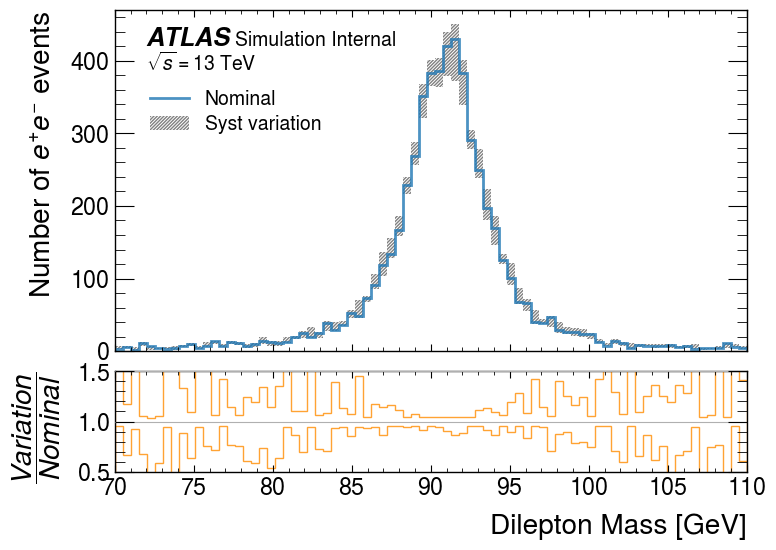

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import mplhep as hep
hep.style.use([hep.style.ATLAS])

#plotting
bins = np.linspace(70, 110, 80)
hist_mcNom = np.histogram(mc_nominal_mass, bins=bins,weights=SF)[0] 
hist_mcSFUp = np.histogram(mc_nominal_mass, bins=bins,weights=SFup)[0]  
hist_mcSFDown = np.histogram(mc_nominal_mass, bins=bins,weights=SFdown)[0]  
hist_mcResUp = np.histogram(mc_corrected_m_Res_UP, bins=bins,weights=SF)[0]  
hist_mcResDown = np.histogram(mc_corrected_m_Res_DOWN, bins=bins,weights=SF)[0]  
hist_mcScaleUp = np.histogram(mc_corrected_m_Scale_UP, bins=bins,weights=SF)[0]  
hist_mcScaleDown = np.histogram(mc_corrected_m_Scale_DOWN, bins=bins,weights=SF)[0]
hist_mcUp = np.max((hist_mcSFUp,hist_mcResUp,hist_mcScaleUp,hist_mcScaleDown,hist_mcSFDown,hist_mcResDown,hist_mcNom),axis=0)
hist_mcDown = np.min((hist_mcSFUp,hist_mcResUp,hist_mcScaleUp,hist_mcScaleDown,hist_mcSFDown,hist_mcResDown,hist_mcNom),axis=0)

fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(4,1,(1,3)) 
ax.bar(
    bins[:-1] + (bins[1] - bins[0])/2,
    hist_mcUp-hist_mcNom,
    width=(bins[1] - bins[0]),
    bottom=hist_mcNom,
    fill=False,
    linewidth=0,
    edgecolor="gray",
    hatch=10 * "/",
    label=("Syst variation")
)     
ax.bar(
bins[:-1] + (bins[1] - bins[0])/2,
    hist_mcNom-hist_mcDown,
    width=(bins[1] - bins[0]),
    bottom=hist_mcDown,
    fill=False,
    linewidth=0,
    edgecolor="gray",
    hatch=10 * "/",
)      
plt.stairs(hist_mcNom,bins, alpha=0.8, linewidth=2,label=("Nominal"))                              
hep.atlas.label(data=False, label="Internal")
ax.legend(bbox_to_anchor=(0.01, 0.85), loc="upper left",)
ax.set_ylabel('Number of $e^{+}e^{-}$ events')
ax.set_ylim(0,np.max(hist_mcUp)+20)
plt.setp(ax.get_xticklabels(), visible=False)
ax = fig.add_subplot(4,1,4)
plt.stairs( np.nan_to_num(hist_mcUp/hist_mcNom,posinf=0), bins,alpha=0.8,linewidth=1,color='darkorange') 
plt.stairs( np.nan_to_num(hist_mcDown/hist_mcNom,posinf=0), bins,alpha=0.8,linewidth=1,color='darkorange') 
ax.set_ylim(0.5,1.5)
ax.set_ylabel(r'$\dfrac{Variation}{Nominal}$')
ax.yaxis.grid()
ax.set_xlabel(r'Dilepton Mass [GeV]')
fig.savefig('plots/Zee_mc.png')

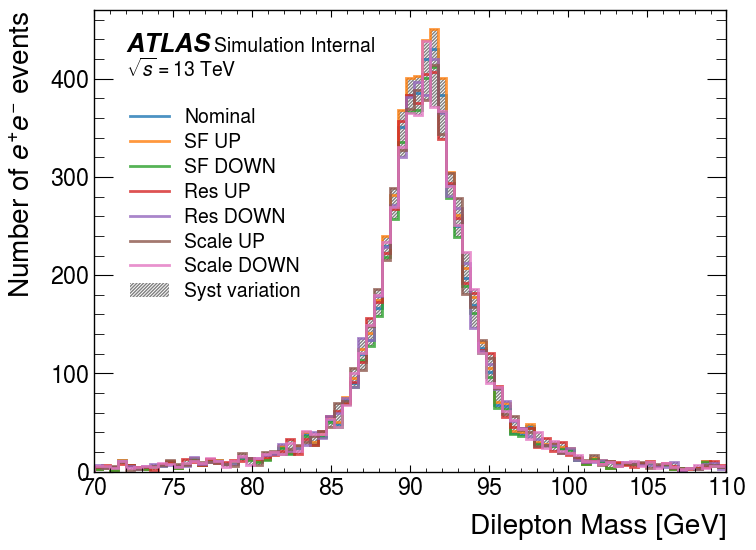

In [18]:
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(4,1,(1,4)) 
ax.bar(
    bins[:-1] + (bins[1] - bins[0])/2,
    hist_mcUp-hist_mcNom,
    width=(bins[1] - bins[0]),
    bottom=hist_mcNom,
    fill=False,
    linewidth=0,
    edgecolor="gray",
    hatch=10 * "/",
    label=("Syst variation")
)     
ax.bar(
    bins[:-1] + (bins[1] - bins[0])/2,
    hist_mcNom-hist_mcDown,
    width=(bins[1] - bins[0]),
    bottom=hist_mcDown,
    fill=False,
    linewidth=0,
    edgecolor="gray",
    hatch=10 * "/",
)      
plt.stairs(hist_mcNom,bins, alpha=0.8, linewidth=2,label=("Nominal")) 
plt.stairs(hist_mcSFUp,bins, alpha=0.8, linewidth=2,label=("SF UP")) 
plt.stairs(hist_mcSFDown,bins, alpha=0.8, linewidth=2,label=("SF DOWN"))  
plt.stairs(hist_mcResUp,bins, alpha=0.8, linewidth=2,label=("Res UP")) 
plt.stairs(hist_mcResDown,bins, alpha=0.8, linewidth=2,label=("Res DOWN"))                              
plt.stairs(hist_mcScaleUp,bins, alpha=0.8, linewidth=2,label=("Scale UP")) 
plt.stairs(hist_mcScaleDown,bins, alpha=0.8, linewidth=2,label=("Scale DOWN"))                              
hep.atlas.label(data=False, label="Internal")
ax.legend(bbox_to_anchor=(0.01, 0.85), loc="upper left",)
ax.set_ylabel('Number of $e^{+}e^{-}$ events')
ax.set_ylim(0,np.max(hist_mcUp)+20)
ax.set_xlabel(r'Dilepton Mass [GeV]')
fig.savefig('plots/Zee_mc_systematics.png')